In [3]:
import cheetah
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense
import wandb
from wandb.keras import WandbCallback

In [4]:
wandb.init(
    project="quadrupole-surrogate-pytorch",
    entity="msk-ipc"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: msk-ipc (use `wandb login --relogin` to force relogin)


In [5]:
n = 5000

### Generate input dataset
Each sample is array of beam parameters, k1 and length.

In [6]:
parameter_keys = ['energy','mu_x','mu_xp','mu_y','mu_yp','sigma_p','sigma_s','sigma_x','sigma_xp','sigma_y','sigma_yp']

In [7]:
parameters = [{
    "mu_x": np.random.uniform(-1e-3, 1e-3),
    "mu_y": np.random.uniform(-1e-3, 1e-3),
    "mu_xp": np.random.uniform(-1e-4, 1e-4),
    "mu_yp": np.random.uniform(-1e-4, 1e-4),
    "sigma_x": np.random.uniform(1e-5, 5e-4),
    "sigma_y": np.random.uniform(1e-5, 5e-4),
    "sigma_xp": np.random.uniform(1e-6, 5e-5),
    "sigma_yp": np.random.uniform(1e-6, 5e-5),
    "sigma_s": np.random.uniform(1e-6, 5e-5),
    "sigma_p": np.random.uniform(1e-4, 1e-3),
    "energy": np.random.uniform(80e6, 160e6)
} for _ in range(n)]

beams = [cheetah.ParameterBeam.from_parameters(**p) for p in parameters]

X1 = np.array([[b.parameters[k] for k in parameter_keys] for b in beams])

X0 = np.array([[np.random.uniform(0.1, 0.3), np.random.uniform(-15.0, 15.0)] for _ in range(n)])

X = np.hstack([X0, X1])

### Generate "label" dataset
Each sample is beam paramters of outgoing beam.

In [8]:
y = []
for incoming, x in zip(beams, X0):
    quadrupole = cheetah.Quadrupole(length=x[0], k1=x[1])
    outgoing = quadrupole(incoming)
    y.append(outgoing)

y = np.array([[b.parameters[k] for k in parameter_keys] for b in y])

### Train ANN
Not comment needed.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [10]:
# Normalisation
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [11]:
model = keras.Sequential([
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(11)
])
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

2022-03-29 15:11:58.398149: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Just test that it doesn't crash
# Make list of length 1 because Keras expects batch of multiple inputs
model.predict(X_train_scaled[0:1])

array([[ 0.36251077, -0.00973265, -0.05018152, -0.20854494,  0.45580605,
         0.01306107,  0.4522051 , -0.24409851, -0.22434995, -0.6310982 ,
         0.23470964]], dtype=float32)

In [13]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    batch_size=64,
    epochs=200,
    validation_data=(X_test_scaled,y_test_scaled),
    callbacks=[WandbCallback()]
)

Epoch 1/200
55/55 [==============================] - 2s 19ms/step - loss: 0.9495 - mae: 0.7862 - val_loss: 0.8356 - val_mae: 0.7282 - _timestamp: 1648559532.0000 - _runtime: 54.0000
Epoch 2/200
55/55 [==============================] - 1s 13ms/step - loss: 0.6961 - mae: 0.6529 - val_loss: 0.5914 - val_mae: 0.5879 - _timestamp: 1648559534.0000 - _runtime: 56.0000
Epoch 3/200
55/55 [==============================] - 1s 22ms/step - loss: 0.4825 - mae: 0.5170 - val_loss: 0.4134 - val_mae: 0.4642 - _timestamp: 1648559535.0000 - _runtime: 57.0000
Epoch 4/200
55/55 [==============================] - 1s 21ms/step - loss: 0.3572 - mae: 0.4261 - val_loss: 0.3303 - val_mae: 0.4046 - _timestamp: 1648559536.0000 - _runtime: 58.0000
Epoch 5/200
55/55 [==============================] - 1s 16ms/step - loss: 0.2955 - mae: 0.3808 - val_loss: 0.2753 - val_mae: 0.3654 - _timestamp: 1648559537.0000 - _runtime: 59.0000
Epoch 6/200
55/55 [==============================] - 2s 25ms/step - loss: 0.2448 - mae: 0.

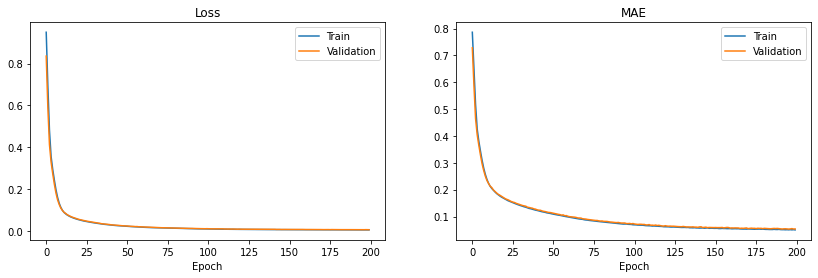

In [14]:
plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("MAE")
plt.plot(history.history["mae"], label="Train")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Try the model
Compare ANN to Cheetah

In [15]:
parameters = {
    "mu_x": np.random.uniform(-1e-3, 1e-3),
    "mu_y": np.random.uniform(-1e-3, 1e-3),
    "mu_xp": np.random.uniform(-1e-4, 1e-4),
    "mu_yp": np.random.uniform(-1e-4, 1e-4),
    "sigma_x": np.random.uniform(1e-5, 5e-4),
    "sigma_y": np.random.uniform(1e-5, 5e-4),
    "sigma_xp": np.random.uniform(1e-6, 5e-5),
    "sigma_yp": np.random.uniform(1e-6, 5e-5),
    "sigma_s": np.random.uniform(1e-6, 5e-5),
    "sigma_p": np.random.uniform(1e-4, 1e-3),
    "energy": np.random.uniform(80e6, 160e6)
}
l = 0.2
k1 = 13.1

In [16]:
incoming = cheetah.ParameterBeam.from_parameters(**parameters)
outgoing = cheetah.Quadrupole(length=l, k1=k1)(incoming)
outgoing

ParameterBeam(mu_x=-0.000444, mu_xp=0.001535, mu_y=-0.000813, mu_yp=-0.001862, sigma_x=0.000161, sigma_xp=0.000515, sigma_y=0.000590, sigma_yp=0.001323, sigma_s=0.000036, sigma_p=0.000414, energy=96388320.572)

In [17]:
X_try = np.array([[l, k1] + [parameters[k] for k in parameter_keys]])
X_try_scaled = X_scaler.transform(X_try)

y_try_scaled = model.predict(X_try_scaled)

y_try = y_scaler.inverse_transform(y_try_scaled)
outgoing = y_try.squeeze()

for k, v in zip(parameter_keys, outgoing):
    print(f"{k} = {v}")

energy = 95933520.0
mu_x = -0.00037338511901907623
mu_xp = 0.00180998130235821
mu_y = -0.0008282114285975695
mu_yp = -0.0018120380118489265
sigma_p = 0.00041974845225922763
sigma_s = 3.649721111287363e-05
sigma_x = 0.00016954037710092962
sigma_xp = 0.0004534504550974816
sigma_y = 0.0005944134900346398
sigma_yp = 0.0012517109280452132
